In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/crime-cast-forecasting-crime-categories/sample.csv
/kaggle/input/crime-cast-forecasting-crime-categories/train.csv
/kaggle/input/crime-cast-forecasting-crime-categories/test.csv


## Import Libraries

In [67]:
## Data manipulation and numerical operations
import numpy as np
import pandas as pd

## Plotting and visualization
import matplotlib.pyplot as plt
import seaborn as sns

## Machine learning models and evaluation
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import xgboost
import lightgbm

## Preprocessing and metrics
from sklearn.preprocessing import MinMaxScaler, FunctionTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, log_loss, confusion_matrix, classification_report, precision_score, recall_score, f1_score
from sklearn.utils.class_weight import compute_sample_weight

## Model selection and evaluation
from sklearn.model_selection import train_test_split, GridSearchCV
## Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

## Enable inline plotting for Jupyter notebooks
%matplotlib inline


## Loading the datasets

In [3]:
sample = pd.read_csv('/kaggle/input/crime-cast-forecasting-crime-categories/sample.csv')
train = pd.read_csv('/kaggle/input/crime-cast-forecasting-crime-categories/train.csv')
test = pd.read_csv('/kaggle/input/crime-cast-forecasting-crime-categories/test.csv')

## Exploring Structure of the Data

In [4]:
# Display the first few rows of the training dataset
dash = "\n-------------------------------------------------\n"
print(dash, "First few rows of the training dataset:", dash)
print(train.head())

# Display a concise summary of the training dataset
print(dash, "Information about the training dataset:", dash)
print(train.info())

# Display basic statistical details of the training dataset
print(dash, "Statistical summary of the training dataset:", dash)
print(train.describe())

# Display a statistical summary of the training dataset including categorical features
print(dash, "Statistical summary including categorical features:", dash)
print(train.describe(include=['O']))


-------------------------------------------------
 First few rows of the training dataset: 
-------------------------------------------------

                                   Location                     Cross_Street  \
0   4500    CARPENTER                    AV                              NaN   
1           45TH                         ST  ALAMEDA                      ST   
2    600 E  MARTIN LUTHER KING JR        BL                              NaN   
3  14900    ORO GRANDE                   ST                              NaN   
4   7100 S  VERMONT                      AV                              NaN   

   Latitude  Longitude           Date_Reported           Date_Occurred  \
0   34.1522  -118.3910  03/09/2020 12:00:00 AM  03/06/2020 12:00:00 AM   
1   34.0028  -118.2391  02/27/2020 12:00:00 AM  02/27/2020 12:00:00 AM   
2   34.0111  -118.2653  08/21/2020 12:00:00 AM  08/21/2020 12:00:00 AM   
3   34.2953  -118.4590  11/08/2020 12:00:00 AM  11/06/2020 12:00:00 AM   
4   3

In [5]:
# Calculate missing values and their percentages
missing_values = train.isnull().sum()
missing_percentages = (missing_values / len(train)) * 100

# Combine results into a DataFrame for better readability
missing_data = pd.DataFrame({
    'Missing Values': missing_values,
    'Percentage': missing_percentages
})

# Display the missing values and their percentages
print("Missing values and their percentages in the training dataset:")
print(missing_data[missing_data['Missing Values'] > 0].sort_values(by='Missing Values', ascending=False))


Missing values and their percentages in the training dataset:
                     Missing Values  Percentage
Cross_Street                  16552      82.760
Weapon_Used_Code              12665      63.325
Weapon_Description            12665      63.325
Modus_Operandi                 2741      13.705
Victim_Sex                     2624      13.120
Victim_Descent                 2624      13.120
Premise_Description               5       0.025


There are a lot of missing values in the training dataset. The following features have missing values (odered by descending order of percentage of missing values):

Cross_Street (82.760%)

Weapon_Used_Code (63.325%)

Weapon_Description (63.325%)

Modus_Operandi (13.705%)

Victim_Sex (13.120%)

Victim_Descent (13.120%)

Premise_Description (0.025%)

## Exploring the testing dataset

In [6]:
# Display the first few rows of the testing dataset
dash = "\n-------------------------------------------------\n"
print(dash, "First few rows of the testing dataset:", dash)
print(test.head())

# Display a concise summary of the testing dataset
print(dash, "Information about the testing dataset:", dash)
print(test.info())

# Display basic statistical details of the testing dataset
print(dash, "Statistical summary of the testing dataset:", dash)
print(test.describe())

# Display a statistical summary of the testing dataset including categorical features
print(dash, "Statistical summary including categorical features:", dash)
print(test.describe(include=['O']))



-------------------------------------------------
 First few rows of the testing dataset: 
-------------------------------------------------

                                   Location Cross_Street  Latitude  Longitude  \
0   1500    LEIGHTON                     AV          NaN   34.0128  -118.3045   
1    100 S  NORMANDIE                    AV          NaN   34.0726  -118.3029   
2    300 E  111TH                        ST          NaN   33.9348  -118.2695   
3   1300 S  LA BREA                      AV          NaN   34.0497  -118.3442   
4  11000    MORRISON                     ST          NaN   34.1611  -118.3704   

            Date_Reported           Date_Occurred  Time_Occurred  Area_ID  \
0  03/03/2020 12:00:00 AM  03/03/2020 12:00:00 AM         2000.0      3.0   
1  06/01/2020 12:00:00 AM  04/25/2020 12:00:00 AM         1700.0     20.0   
2  08/28/2020 12:00:00 AM  08/27/2020 12:00:00 AM          900.0     18.0   
3  12/23/2020 12:00:00 AM  12/03/2020 12:00:00 AM         2200

In [7]:
# Calculate missing values and their percentages
missing_values = test.isnull().sum()
missing_percentages = (missing_values / len(test)) * 100

# Combine results into a DataFrame for better readability
missing_data = pd.DataFrame({
    'Missing Values': missing_values,
    'Percentage': missing_percentages
})

# Display the missing values and their percentages
print("Missing values and their percentages in the testing dataset:")
print(missing_data[missing_data['Missing Values'] > 0].sort_values(by='Missing Values', ascending=False))


Missing values and their percentages in the testing dataset:
                     Missing Values  Percentage
Cross_Street                   4190       83.80
Weapon_Used_Code               3153       63.06
Weapon_Description             3153       63.06
Modus_Operandi                  684       13.68
Victim_Sex                      643       12.86
Victim_Descent                  643       12.86
Premise_Description               1        0.02


There are a lot of missing values in the test dataset. The following features have missing values (odered by descending order of percentage of missing values):

Cross_Street (83.0%)

Weapon_Used_Code (63.06%)

Weapon_Description (63.06%)

Modus_Operandi (13.68%)

Victim_Sex (12.86%)

Victim_Descent (12.86%)

Premise_Description (0.02%)

This percentage distribution is more or less the same as the training set.

-----------------------------------------------

There are redundant columns such as 'Location', 'Area_Name', 'Premise_Description', 'Status_Description', 'Date_Reported' 'Weapon_Description' which can be dropped.

## Exploratory Data Analysis

### Share of Crime_Category

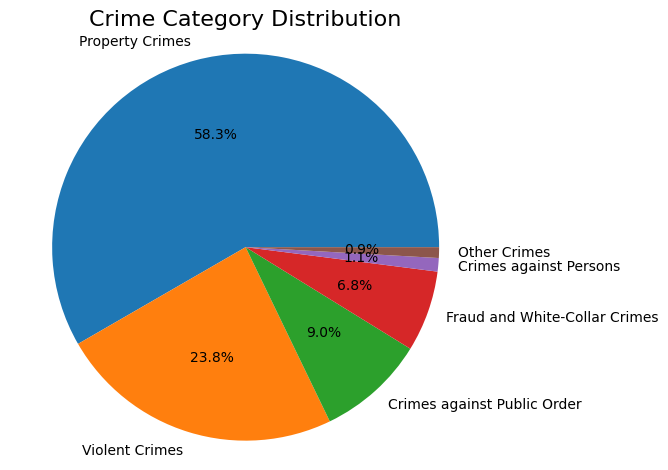

In [8]:
# Visualizing the share of classification of Crime_Category
values = pd.Series(train['Crime_Category'])
v_counts = values.value_counts()
total = len(values)

# Create the pie chart
fig, ax = plt.subplots()
ax.pie(v_counts, labels=v_counts.index, autopct='%1.1f%%')

# Equal aspect ratio ensures the pie chart is a circle.
ax.axis('equal')  

# Title
plt.title("Crime Category Distribution", fontsize=16)

# Improve layout
plt.tight_layout()

# Show the plot
plt.show()

### Outliers in Numerical Columns

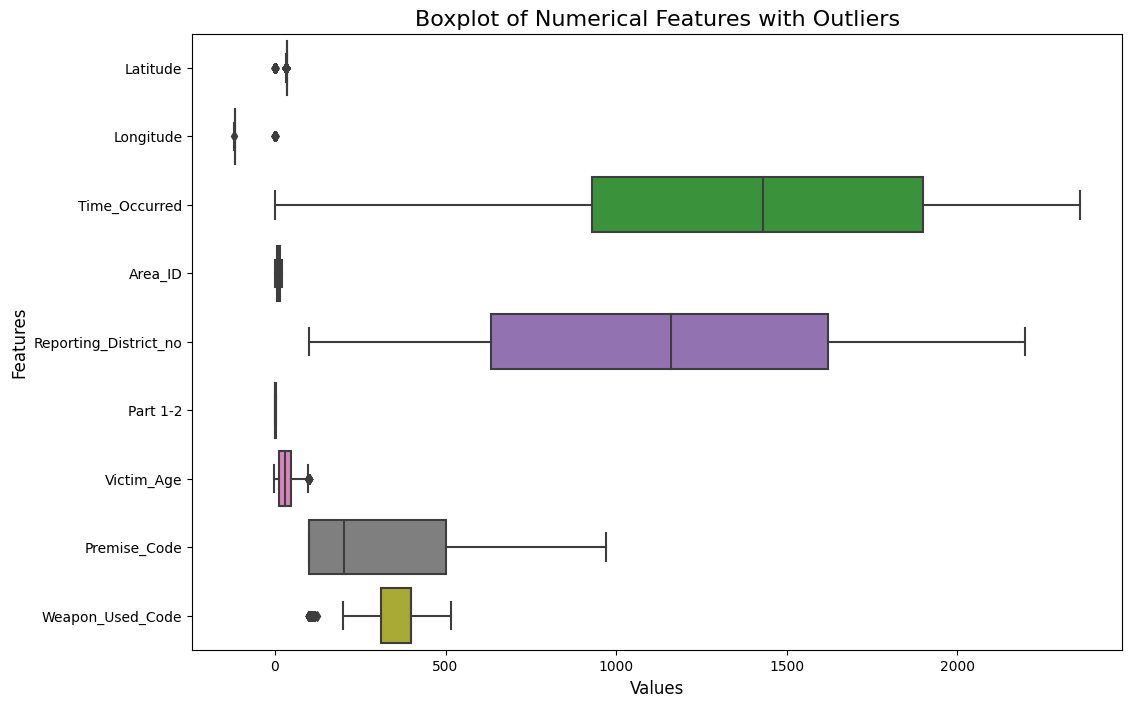

In [9]:
# Extract numerical columns
numerical_train = train.select_dtypes(include=['float64', 'int64'])

# Calculate Q1 (25th percentile) and Q3 (75th percentile)
Q1 = numerical_train.quantile(0.25)
Q3 = numerical_train.quantile(0.75)
IQR = Q3 - Q1

# Define outlier condition (typically 1.5 times the IQR)
outliers = ((numerical_train < (Q1 - 1.5 * IQR)) | (numerical_train > (Q3 + 1.5 * IQR)))

# Filter rows that have outliers
outliers_train = numerical_train[outliers.any(axis=1)]

# Create a box plot for each numerical column
plt.figure(figsize=(12, 8))
sns.boxplot(data=numerical_train, orient="h")

plt.title("Boxplot of Numerical Features with Outliers", fontsize=16)
plt.xlabel("Values", fontsize=12)
plt.ylabel("Features", fontsize=12)
plt.show()

### Geographical Analysis

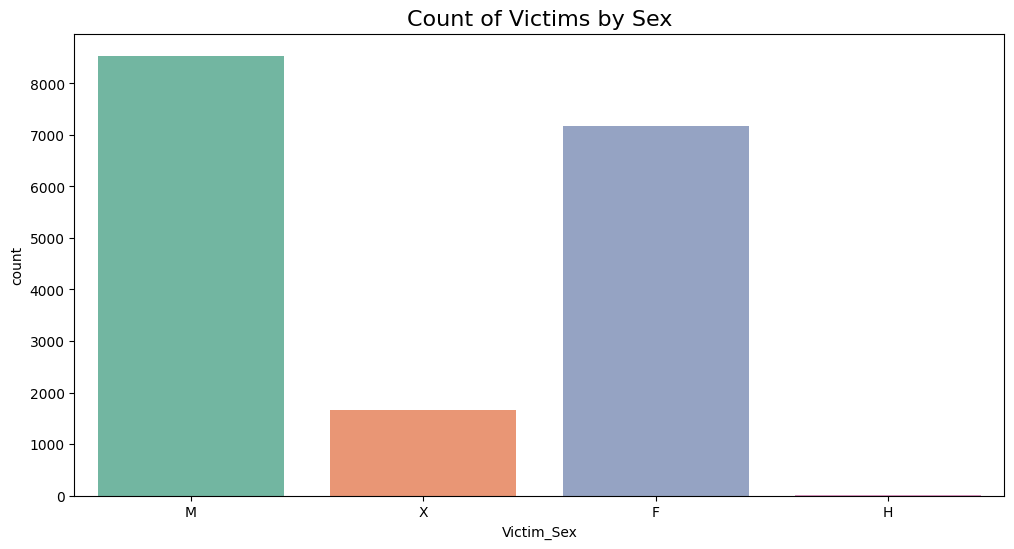

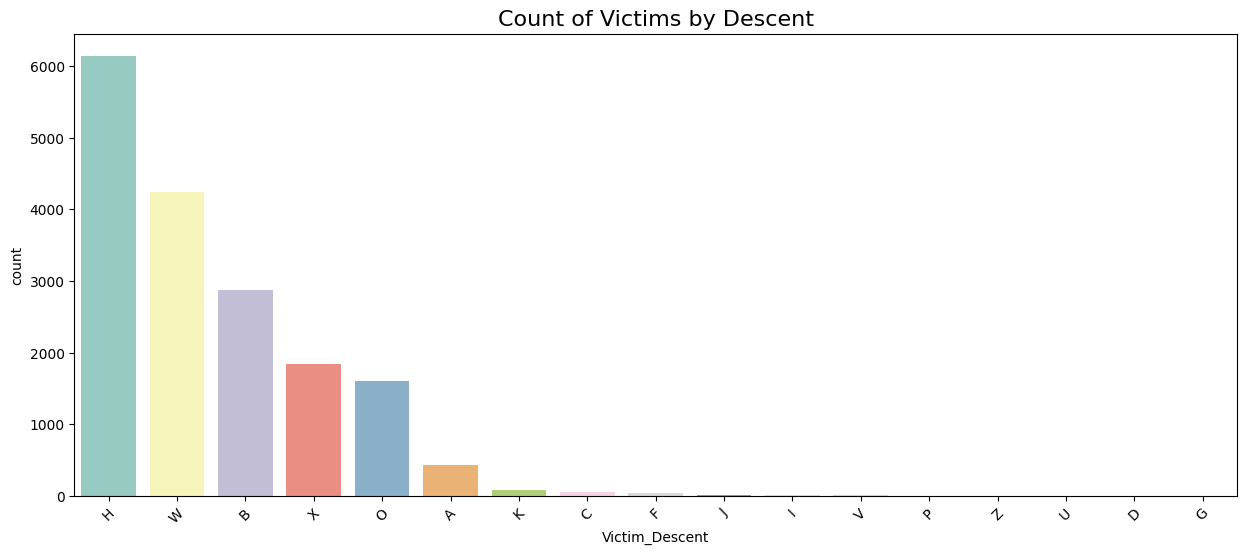

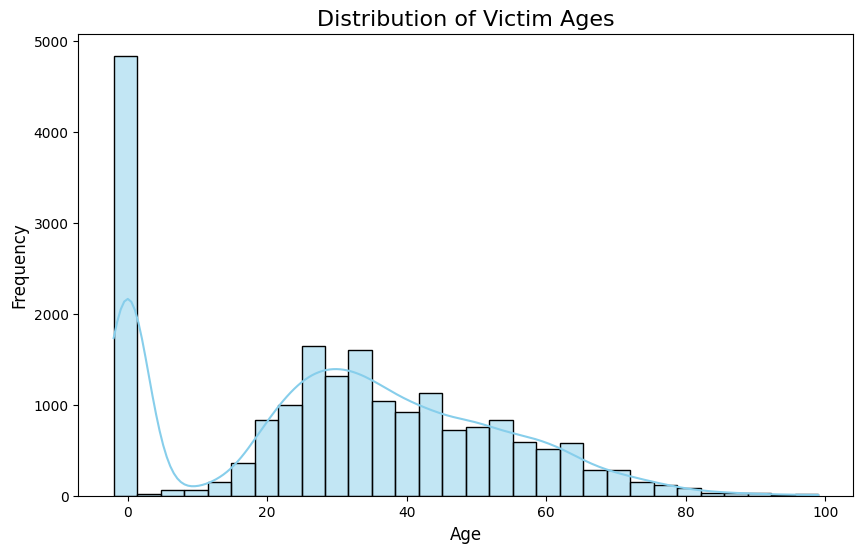

In [10]:
# Count Plot for Victim_Sex and Victim_Descent
plt.figure(figsize=(12, 6))
sns.countplot(x='Victim_Sex', data=train, palette='Set2')
plt.title('Count of Victims by Sex', fontsize=16)
plt.show()

plt.figure(figsize=(15, 6))
sns.countplot(x='Victim_Descent', data=train, palette='Set3', order=train['Victim_Descent'].value_counts().index)
plt.title('Count of Victims by Descent', fontsize=16)
plt.xticks(rotation=45)
plt.show()

# Age Distribution
plt.figure(figsize=(10, 6))
sns.histplot(train['Victim_Age'], bins=30, kde=True, color='skyblue')
plt.title('Distribution of Victim Ages', fontsize=16)
plt.xlabel('Age', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.show()


### Victim Demographics

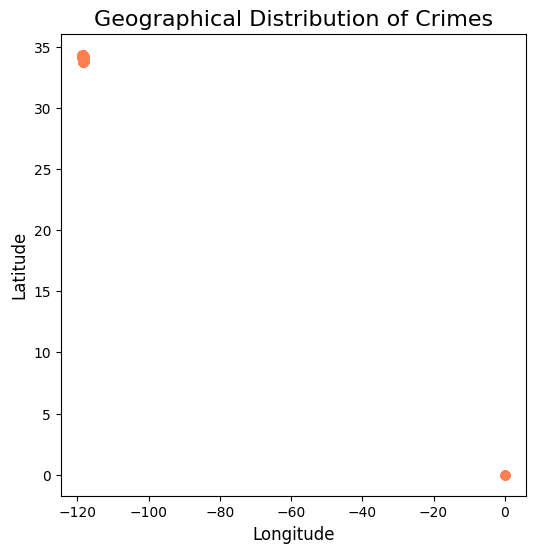

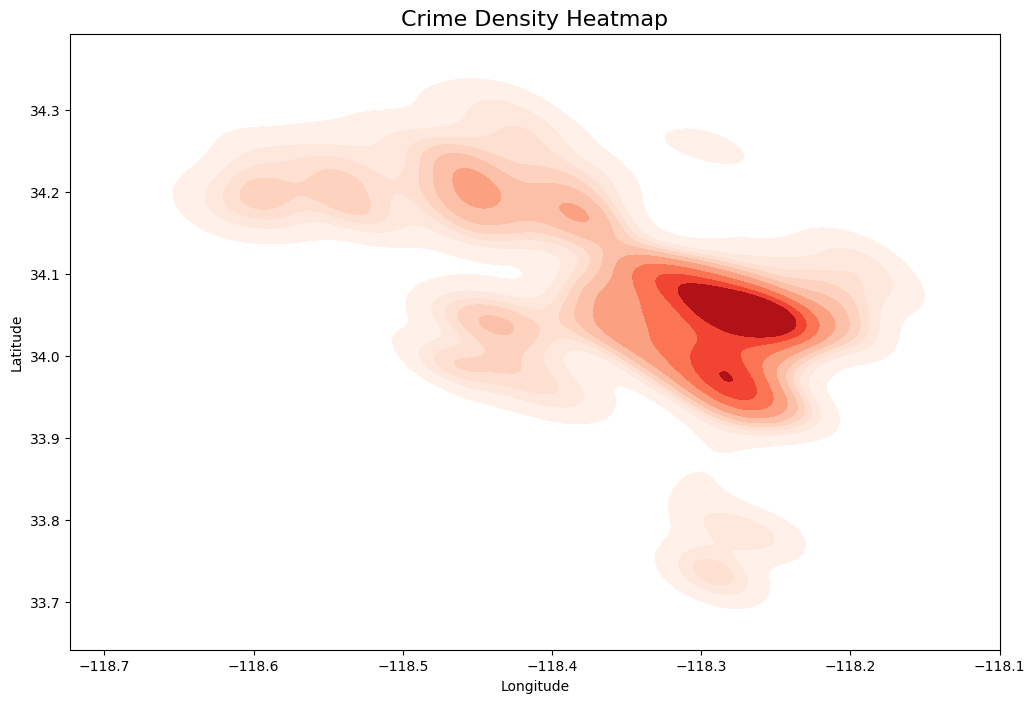

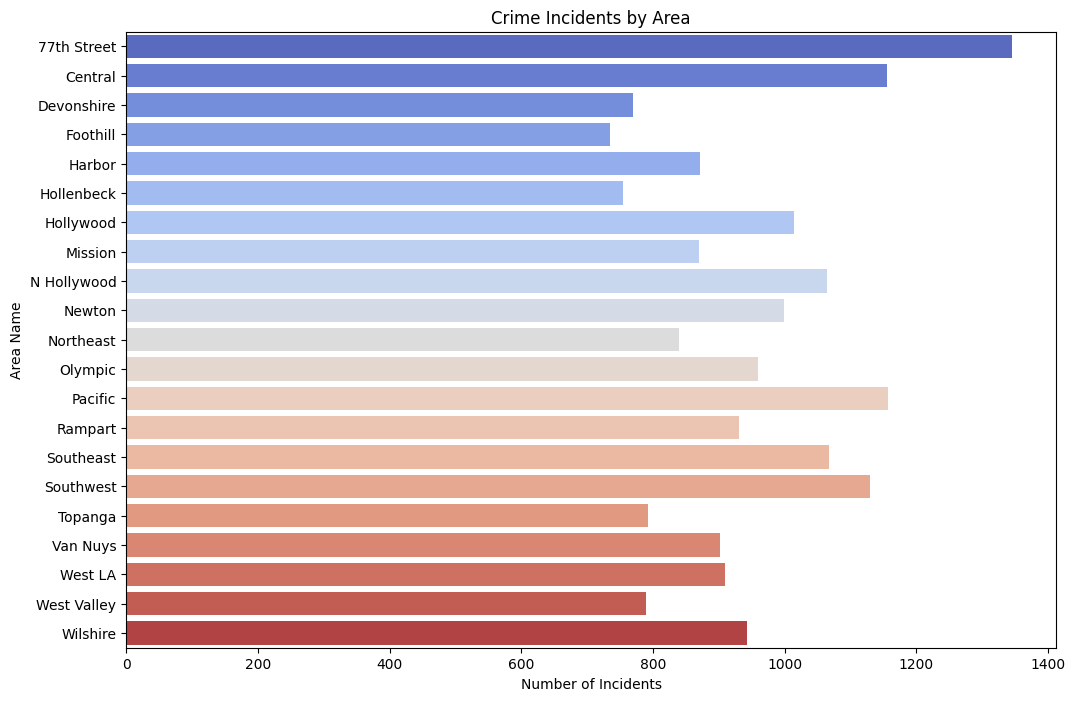

In [11]:
# Scatter Plot
plt.figure(figsize=(6, 6))
plt.scatter(train['Longitude'], train['Latitude'], alpha=0.5, color='coral')
plt.title('Geographical Distribution of Crimes', fontsize=16)
plt.xlabel('Longitude', fontsize=12)
plt.ylabel('Latitude', fontsize=12)
plt.show()

# Filter out rows where Longitude or Latitude is 0 (likely erroneous)
filtered_train = train[(train['Longitude'] != 0) & (train['Latitude'] != 0)]

# Heatmap (if data is more granular)
plt.figure(figsize=(12, 8))
sns.kdeplot(x=filtered_train['Longitude'], y=filtered_train['Latitude'], cmap='Reds', fill=True)
plt.title('Crime Density Heatmap', fontsize=16)
plt.show()

# Count the number of incidents in each area
area_counts = train.groupby('Area_Name').size().reset_index(name='Incident_Count')

# Sort by area name to maintain a consistent order
area_counts = area_counts.sort_values(by='Area_Name')

# Plot the heatmap using a barplot instead
plt.figure(figsize=(12, 8))
sns.barplot(x='Incident_Count', y='Area_Name', data=area_counts, palette='coolwarm')
plt.title('Crime Incidents by Area')
plt.xlabel('Number of Incidents')
plt.ylabel('Area Name')
plt.show()

### Temporal Analysis

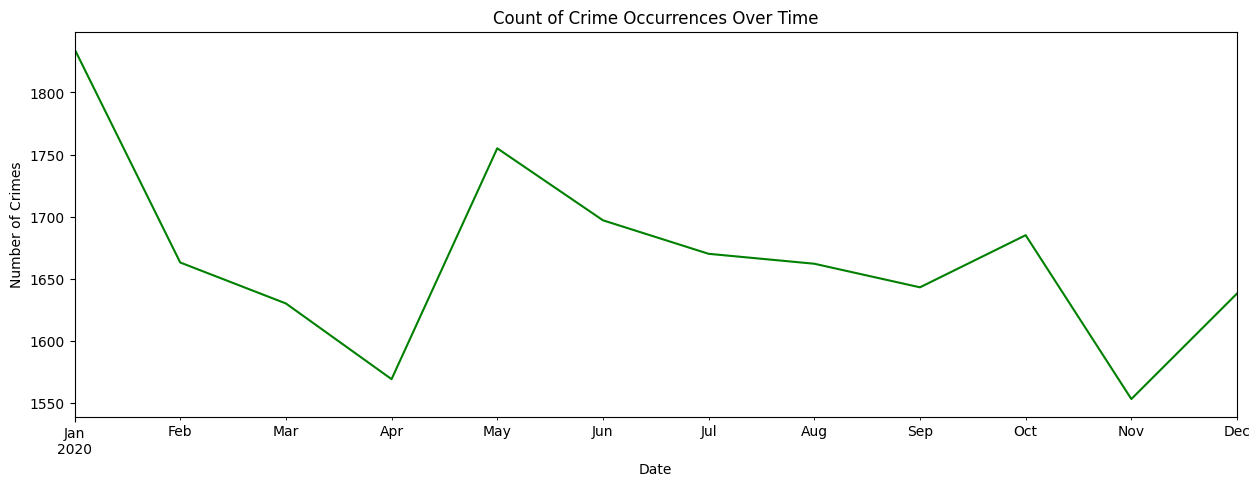

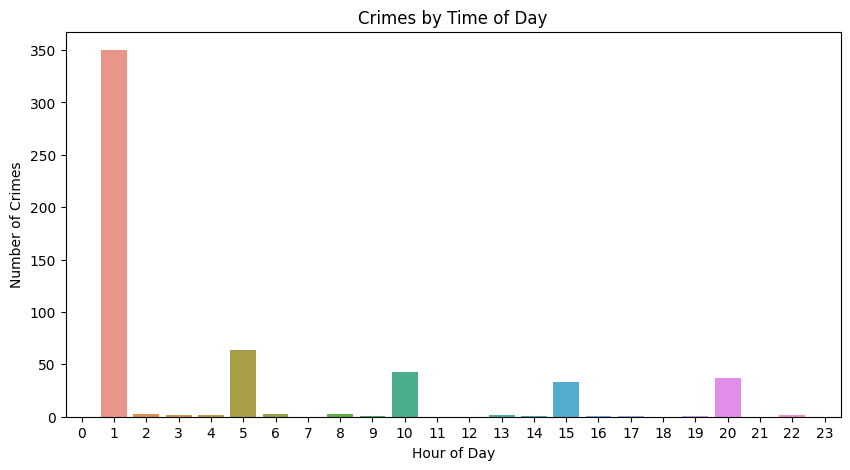

In [12]:
# Convert 'Date_Occurred' to datetime if not already done
train['Date_Occurred'] = pd.to_datetime(train['Date_Occurred'])

# Plot crimes over time
plt.figure(figsize=(15, 5))
train.groupby(train['Date_Occurred'].dt.to_period('M')).size().plot(color='green')
plt.title('Count of Crime Occurrences Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Crimes')
plt.show()

# Distribution of crimes by hour
plt.figure(figsize=(10, 5))
sns.countplot(x=train['Time_Occurred'], order=range(24))
plt.title('Crimes by Time of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Crimes')
plt.show()

### Weapon Usage

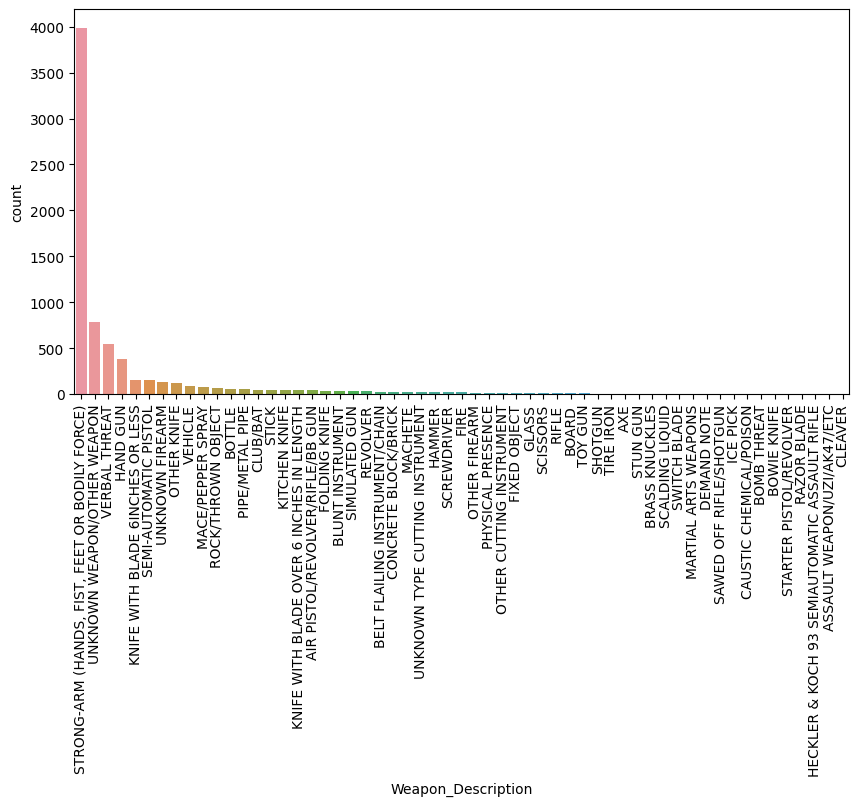

In [13]:
plt.figure(figsize=(10, 5))
sns.countplot(x=train['Weapon_Description'], data=train, order=train['Weapon_Description'].value_counts().index)
plt.xticks(rotation=90)
plt.show()

## Observation
**Dataset Overview**

    - The training dataset comprises 20,000 rows and 22 columns.

    Columns Description:

        - Location: Street address of the crime incident.
        - Cross_Street: Cross street of the rounded address.
        - Latitude: Latitude coordinates of the crime incident.
        - Longitude: Longitude coordinates of the crime incident.
        - Date_Reported: Date the incident was reported.
        - Date_Occurred: Date the incident occurred.
        - Time_Occurred: Time the incident occurred in 24-hour military time.
        - Area_ID: LAPD's Geographic Area number.
        - Area_Name: Name designation of the LAPD Geographic Area.
        - Reporting_District_no: Reporting district number.
        - Part 1-2: Crime classification.
        - Modus_Operandi: Activities associated with the suspect.
        - Victim_Age: Age of the victim.
        - Victim_Sex: Gender of the victim.
        - Victim_Descent: Descent code of the victim.
        - Premise_Code: Premise code indicating the location of the crime.
        - Premise_Description: Description of the premise code.
        - Weapon_Used_Code: Weapon code indicating the type of weapon used.
        - Weapon_Description: Description of the weapon code.
        - Status: Status of the case.
        - Status_Description: Description of the status code.
        - Crime_Category: The category of the crime (Target Variable)

**Missing Values (Percentage)**

    - Cross_Street: 82.760%
    - Modus_Operandi: 13.705%
    - Victim_Sex: 13.120%
    - Victim_Descent: 13.120%
    - Premise_Description: 0.025%
    - Weapon_Used_Code: 63.325%
    - Weapon_Description: 63.325%

**Crime Category Distribution**

    - Property Crimes: Highest number of incidents
    - Violent Crimes: Second highest
    - Crimes against Public Order: Third highest
    
**Data Outliers**

    - Victim_Age, Latitude, and Longitude contain outliers.
    - The dataset focuses on Coastal California, making the (0, 0) coordinates unnecessary. Rows with these coordinates should be removed.

**Crime Locations**

    - 77th Street: Highest number of crimes
    - Followed by: Pacific, Central, Southwest, Southeast, North Hollywood, Hollywood, etc.

**Victim Demographics**

    Victim Age:

        - Majority of victims are recorded as 0 years old, indicating children are the most frequent victims.
        - Some ages are negative, suggesting unknown victim ages.

    Victim Gender:

        - Male: Most frequent
        - Female: Second most frequent
        - Followed by: X and H

    Victim Descent Distribution (descending):

        - H, W, B, X, O, A, K, C, F, J, I, V, P, U, D, G

**Crime Occurrence Patterns**

    Monthly Crime Frequency:
    
        - Most frequent in January and May
        - Least frequent in April and November

    Hourly Crime Frequency:

    - Most frequent at 01:00, 05:00, 10:00, 15:00, and 20:00

**Weapon Usage**

    - Strong- arm
    - Weapon unknown
    - Verbal threat
    - Handgun
    - Knife with blade 6 inches or less

**Case Status Distribution (descending)**

    - Invest Count
    - Audit Other
    - Audit Arrest
    - Juv Arrest
    - Juv Other


## Preprocessing

### Training set

In [14]:
## Dropping duplicates
train.drop_duplicates(inplace=True)

## Setting the negatives from Victim_Age to 0
train['Victim_Age'] = train['Victim_Age'].apply(lambda x: 0 if x< 0 else x)
lat_long_zero = train[(train['Latitude'] == 0) & (train['Longitude']==0)].index
train.drop(lat_long_zero, inplace=True)
train.shape

(19909, 22)

In [15]:
## Replace None and empty strings with NaN
processed_train = train.replace({None: np.nan, "": np.nan, "-": np.nan})

## Replace NaN values with 0
processed_train = processed_train.fillna(value=0)

target_encoded = ['Crimes against Persons', 'Crimes against Public Order', 'Fraud and White-Collar Crimes', 'Other Crimes', 'Property Crimes', 'Violent Crimes']

# Apply the mapping using the list index method inside a lambda function
processed_train['Crime_Category'] = processed_train['Crime_Category'].apply(lambda crime: target_encoded.index(crime))

## Create binary columns based on whether the original columns have values
processed_train['is_cross_street'] = train['Cross_Street'].apply(lambda x : 0 if x == 0 else 1)
processed_train['is_victim_age'] = train['Victim_Age'].apply(lambda x : 0 if x == 0 else 1)
processed_train['is_weapon_used'] = train['Weapon_Used_Code'].apply(lambda x : 0 if x == 0 else 1)

## Calculate the difference in days between reported and occurred dates
date_reported = pd.to_datetime(train['Date_Reported'])
date_occurred = pd.to_datetime(train['Date_Occurred'])
processed_train['days_lapsed'] = (date_reported - date_occurred).dt.days

## Extract date and time features
processed_train['day_occurred'] = date_occurred.dt.day
processed_train['day_of_week_occurred'] = date_occurred.dt.weekday
processed_train['month_occurred'] = date_occurred.dt.month
processed_train['day_of_year_occurred'] = date_occurred.dt.dayofyear

processed_train['day_reported'] = date_reported.dt.day
processed_train['day_of_week_reported'] = date_reported.dt.weekday
processed_train['month_reported'] = date_reported.dt.month
processed_train['day_of_year_reported'] = date_reported.dt.dayofyear

## Extract hour from time occurred
processed_train['hour_occurred'] = train['Time_Occurred'].floordiv(100)

## Convert specified columns to integer
columns_to_int = [ 'Reporting_District_no', 'Part 1-2', 'Premise_Code']
processed_train[['reporting_district_no', 'part 1-2', 'premise_code']] = train[columns_to_int].astype(int)

## Check train info and first few rows to verify the changes
processed_train.info()
processed_train.head()

<class 'pandas.core.frame.DataFrame'>
Index: 19909 entries, 0 to 19999
Data columns (total 38 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Location               19909 non-null  object        
 1   Cross_Street           19909 non-null  object        
 2   Latitude               19909 non-null  float64       
 3   Longitude              19909 non-null  float64       
 4   Date_Reported          19909 non-null  object        
 5   Date_Occurred          19909 non-null  datetime64[ns]
 6   Time_Occurred          19909 non-null  float64       
 7   Area_ID                19909 non-null  float64       
 8   Area_Name              19909 non-null  object        
 9   Reporting_District_no  19909 non-null  float64       
 10  Part 1-2               19909 non-null  float64       
 11  Modus_Operandi         19909 non-null  object        
 12  Victim_Age             19909 non-null  float64       
 13  Victim

,Location,Cross_Street,Latitude,Longitude,Date_Reported,Date_Occurred,Time_Occurred,Area_ID,Area_Name,Reporting_District_no,...,month_occurred,day_of_year_occurred,day_reported,day_of_week_reported,month_reported,day_of_year_reported,hour_occurred,reporting_district_no,part 1-2,premise_code
0,4500 CARPENTER AV,0,34.1522,-118.3910,03/09/2020 12:00:00 AM,2020-03-06,1800.0,15.0,N Hollywood,1563.0,...,3,66,9,0,3,69,18.0,1563,1,101
1,45TH ST,ALAMEDA ST,34.0028,-118.2391,02/27/2020 12:00:00 AM,2020-02-27,1345.0,13.0,Newton,1367.0,...,2,58,27,3,2,58,13.0,1367,1,216
2,600 E MARTIN LUTHER KING JR BL,0,34.0111,-118.2653,08/21/2020 12:00:00 AM,2020-08-21,605.0,13.0,Newton,1343.0,...,8,234,21,4,8,234,6.0,1343,2,501
3,14900 ORO GRANDE ST,0,34.2953,-118.4590,11/08/2020 12:00:00 AM,2020-11-06,1800.0,19.0,Mission,1924.0,...,11,311,8,6,11,313,18.0,1924,1,101
4,7100 S VERMONT AV,0,33.9787,-118.2918,02/25/2020 12:00:00 AM,2020-02-25,1130.0,12.0,77th Street,1245.0,...,2,56,25,1,2,56,11.0,1245,1,401


In [16]:
# List of columns to check for outliers
columns = ['Latitude', 'Longitude', 'Victim_Age']

for column in columns:
    Q1 = train[column].quantile(0.25)
    Q3 = train[column].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Remove outliers
    train = train[(train[column] > lower_bound) & (train[column] < upper_bound)]

# Display the shape of the DataFrame after outlier removal
print(train.shape)

(19434, 22)


In [17]:
# Calculate the mean and standard deviation
mean = np.mean(processed_train['days_lapsed'])
std = np.std(processed_train['days_lapsed'])

# Define the threshold for z-score
threshold = 3

# Calculate z-scores for all data points and filter out the outliers
processed_train = processed_train[np.abs((processed_train['days_lapsed'] - mean) / std) <= threshold]

# Display the shape of the DataFrame to verify the operation
print(processed_train.shape)

(19550, 38)


## Heat Map for Coorelation

<Axes: >

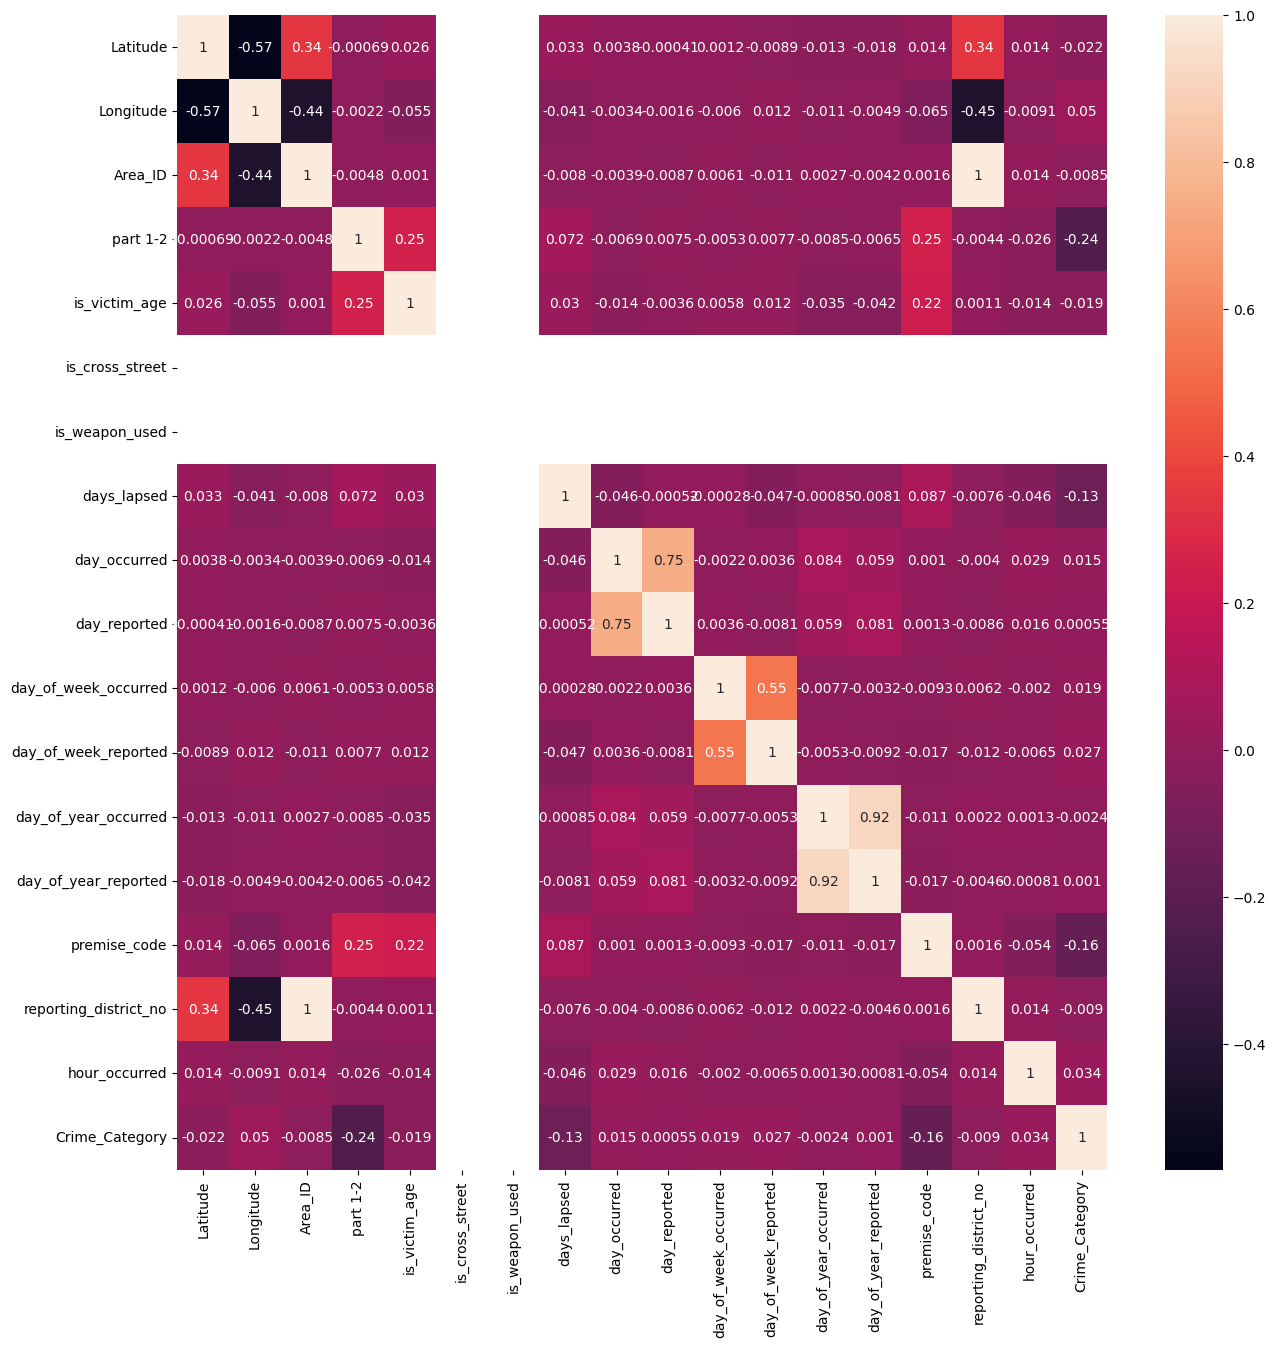

In [77]:
corr_df = processed_train[['Latitude', 'Longitude', 'Area_ID','part 1-2', 'is_victim_age', 'is_cross_street', 'is_weapon_used', 'days_lapsed', 
                           'day_occurred','day_reported', 'day_of_week_occurred', 'day_of_week_reported',
                           'day_of_year_occurred', 'day_of_year_reported', 'premise_code',
                           'reporting_district_no', 'hour_occurred', 'Crime_Category']]

corr_df = corr_df.corr()
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(corr_df, cmap = 'rocket', annot=True)

### Testing Set

In [19]:
## Replace None and empty strings with NaN
processed_test = test.replace({None: np.nan, "": np.nan, "-": np.nan})

## Replace NaN values with 0
processed_test = processed_test = processed_test.fillna(value=0)

## Create binary columns based on whether the original columns have values
processed_test['is_cross_street'] = test['Cross_Street'].notna().astype(int)
processed_test['is_victim_age'] = test['Victim_Age'].notna().astype(int)
processed_test['is_weapon_used'] = test['Weapon_Used_Code'].apply(lambda x : 0 if x == 0 else 1)

## Calculate the difference in days between reported and occurred dates
date_reported = pd.to_datetime(test['Date_Reported'])
date_occurred = pd.to_datetime(test['Date_Occurred'])
processed_test['days_lapsed'] = (date_reported - date_occurred).dt.days

## Extract date and time features
processed_test['day_occurred'] = date_occurred.dt.day
processed_test['day_of_week_occurred'] = date_occurred.dt.weekday
processed_test['month_occurred'] = date_occurred.dt.month
processed_test['day_of_year_occurred'] = date_occurred.dt.dayofyear

processed_test['day_reported'] = date_reported.dt.day
processed_test['day_of_week_reported'] = date_reported.dt.weekday
processed_test['month_reported'] = date_reported.dt.month
processed_test['day_of_year_reported'] = date_reported.dt.dayofyear

## Extract hour from time occurred
processed_test['hour_occurred'] = test['Time_Occurred'].floordiv(100)

## Convert specified columns to integer
columns_to_int = [ 'Reporting_District_no', 'Part 1-2', 'Premise_Code']
processed_test[['reporting_district_no', 'part 1-2', 'premise_code']] = test[columns_to_int].astype(int)

## Check test info and first few rows to verify the changes
processed_test.info()
processed_test.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 37 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Location               5000 non-null   object 
 1   Cross_Street           5000 non-null   object 
 2   Latitude               5000 non-null   float64
 3   Longitude              5000 non-null   float64
 4   Date_Reported          5000 non-null   object 
 5   Date_Occurred          5000 non-null   object 
 6   Time_Occurred          5000 non-null   float64
 7   Area_ID                5000 non-null   float64
 8   Area_Name              5000 non-null   object 
 9   Reporting_District_no  5000 non-null   float64
 10  Part 1-2               5000 non-null   float64
 11  Modus_Operandi         5000 non-null   object 
 12  Victim_Age             5000 non-null   float64
 13  Victim_Sex             5000 non-null   object 
 14  Victim_Descent         5000 non-null   object 
 15  Prem

,Location,Cross_Street,Latitude,Longitude,Date_Reported,Date_Occurred,Time_Occurred,Area_ID,Area_Name,Reporting_District_no,...,month_occurred,day_of_year_occurred,day_reported,day_of_week_reported,month_reported,day_of_year_reported,hour_occurred,reporting_district_no,part 1-2,premise_code
0,1500 LEIGHTON AV,0,34.0128,-118.3045,03/03/2020 12:00:00 AM,03/03/2020 12:00:00 AM,2000.0,3.0,Southwest,376.0,...,3,63,3,1,3,63,20.0,376,2,501
1,100 S NORMANDIE AV,0,34.0726,-118.3029,06/01/2020 12:00:00 AM,04/25/2020 12:00:00 AM,1700.0,20.0,Olympic,2014.0,...,4,116,1,0,6,153,17.0,2014,1,502
2,300 E 111TH ST,0,33.9348,-118.2695,08/28/2020 12:00:00 AM,08/27/2020 12:00:00 AM,900.0,18.0,Southeast,1844.0,...,8,240,28,4,8,241,9.0,1844,2,721
3,1300 S LA BREA AV,0,34.0497,-118.3442,12/23/2020 12:00:00 AM,12/03/2020 12:00:00 AM,2200.0,7.0,Wilshire,765.0,...,12,338,23,2,12,358,22.0,765,1,108
4,11000 MORRISON ST,0,34.1611,-118.3704,08/30/2020 12:00:00 AM,08/29/2020 12:00:00 AM,130.0,15.0,N Hollywood,1555.0,...,8,242,30,6,8,243,1.0,1555,2,501


In [20]:
## List of columns to drop
columns_to_drop = [
    'Location', 'Cross_Street', 'Date_Reported', 'Date_Occurred', 'Time_Occurred', 'Area_Name', 'Reporting_District_no', 'Part 1-2', 
    'Premise_Code', 'Premise_Description', 'Weapon_Used_Code', 'Weapon_Description', 'Status_Description'
]

## Drop the columns in both processed_train and processed_test DataFrames
processed_train.drop(columns=columns_to_drop, inplace=True)
processed_test.drop(columns=columns_to_drop, inplace=True)

### Handling Modus Operandi

#### Training

In [21]:
# Create a one-hot encoded DataFrame for 'Modus_Operandi'

# Drop rows with NaNs in 'Modus_Operandi' column
processed_train = processed_train.dropna(subset=['Modus_Operandi'])

# Convert 'Modus_Operandi' to string
processed_train['Modus_Operandi'] = processed_train['Modus_Operandi'].astype(str)

# Initialize CountVectorizer to split by space and convert to one-hot encoding
vectorizer = CountVectorizer()
modus_matrix = vectorizer.fit_transform(processed_train['Modus_Operandi'])

# Get the feature names (unique words) and create a DataFrame
modus_df = pd.DataFrame(modus_matrix.toarray(), columns=['Modus_' + col for col in vectorizer.get_feature_names_out()])

# Concatenate the new DataFrame with the original DataFrame
processed_train = pd.concat([processed_train.reset_index(drop=True), modus_df.reset_index(drop=True)], axis=1)

# Drop the original 'Modus_Operandi' column
processed_train.drop(['Modus_Operandi'], axis=1, inplace=True)

# Display the final DataFrame
processed_train.shape
processed_train.head()

,Latitude,Longitude,Area_ID,Victim_Age,Victim_Sex,Victim_Descent,Status,Crime_Category,is_cross_street,is_victim_age,...,Modus_2126,Modus_2157,Modus_2201,Modus_2204,Modus_2303,Modus_2304,Modus_3003,Modus_3004,Modus_4025,Modus_9999
0,34.1522,-118.3910,15.0,75.0,M,W,IC,4,1,1,...,0,0,0,0,0,0,0,0,0,0
1,34.0028,-118.2391,13.0,41.0,M,H,IC,4,1,1,...,0,0,0,0,0,0,0,0,0,0
2,34.0111,-118.2653,13.0,67.0,M,B,IC,4,1,1,...,0,0,0,0,0,0,0,0,0,0
3,34.2953,-118.4590,19.0,61.0,M,H,IC,4,1,1,...,0,0,0,0,0,0,0,0,0,0
4,33.9787,-118.2918,12.0,0.0,X,X,IC,4,1,0,...,0,0,0,0,0,0,0,0,0,0


#### Testing

In [22]:
# Fill NaNs with empty strings to avoid issues during transformation
processed_test['Modus_Operandi'] = processed_test['Modus_Operandi'].replace({None: ""})

# Convert 'Modus_Operandi' to string
processed_test['Modus_Operandi'] = processed_test['Modus_Operandi'].astype(str)

# Transform the test data using the same vectorizer
modus_test_matrix = vectorizer.transform(processed_test['Modus_Operandi'])

# Get the feature names and create a DataFrame
modus_test_unique = pd.DataFrame(modus_test_matrix.toarray(), columns=['Modus_' + col for col in vectorizer.get_feature_names_out()])

# Concatenate the new DataFrame with the original DataFrame
processed_test = pd.concat([processed_test.reset_index(drop=True), modus_test_unique.reset_index(drop=True)], axis=1)

# Drop the original 'Modus_Operandi' column
processed_test.drop(['Modus_Operandi'], axis=1, inplace=True)

# Display the final DataFrame for test data
processed_test.info()
processed_test.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Columns: 504 entries, Latitude to Modus_9999
dtypes: float64(5), int32(8), int64(488), object(3)
memory usage: 19.1+ MB


(5000, 504)

### Scaling using MinMaxScaler

In [23]:
# List of numerical columns to normalize
numerical_cols = [
    'Latitude', 'Longitude', 'Area_ID', 'Victim_Age',
    'days_lapsed', 'day_occurred', 'day_of_week_occurred',
    'month_occurred', 'day_of_year_occurred', 'day_reported', 'day_of_week_reported',
    'day_of_year_reported', 'hour_occurred', 'reporting_district_no', 'reporting_district_no',
    'part 1-2', 'premise_code'
]

# Initialize MinMaxScaler
scaler = MinMaxScaler()

# Normalize the numerical columns in the training data
processed_train[numerical_cols] = scaler.fit_transform(processed_train[numerical_cols])

# Normalize the numerical columns in the test data using the same scaler
processed_test[numerical_cols] = scaler.transform(processed_test[numerical_cols])

# Display the shape of the DataFrames to verify the operation
print(processed_train.shape)
print(processed_test.shape)

(19550, 505)
(5000, 504)


### Converting Categorical Columns to Dummies

In [24]:
# Convert categorical columns to dummies for the training set and concatenate
cat_cols = ['Victim_Sex', 'Victim_Descent', 'Status']
train_dummies = pd.get_dummies(processed_train[cat_cols], dtype="int8")
train_final = pd.concat([processed_train, train_dummies], axis=1)

# Drop the original categorical columns from the training set
train_final.drop(columns=cat_cols, inplace=True)

# Convert categorical columns to dummies for the test set using the same columns as the training set
test_dummies = pd.get_dummies(processed_test[cat_cols], dtype="int8")

# Add missing columns in test_dummies to match train_dummies columns
for col in train_dummies.columns:
    if col not in test_dummies:
        test_dummies[col] = 0

# Ensure the order of columns in test_dummies is the same as in train_dummies
test_dummies = test_dummies[train_dummies.columns]

# Concatenate the dummy variables with the original 'processed_test' DataFrame
test_final = pd.concat([processed_test, test_dummies], axis=1)

# Drop the original categorical columns from the test set
test_final.drop(columns=cat_cols, inplace=True)

# Print the shape to verify the operation
print(train_final.shape)
print(test_final.shape)

(19550, 530)
(5000, 529)


In [25]:
## Final check for null values before proceeding into training and validation
train_final.isna().sum().sum(), test_final.isna().sum().sum()

(0, 0)

## Training and Validation

In [26]:
X = train_final.drop(columns = ['Crime_Category'], axis = 1)
y = train_final['Crime_Category']

In [27]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 42)

### RandomForestClassifier

In [28]:
rfc = RandomForestClassifier(random_state=42)

# Train the model
rfc.fit(X_train, y_train)

# Make predictions on the validation set
y_pred = rfc.predict(X_val)

# Evaluate the model
accuracy = accuracy_score(y_val, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Print classification report
print("\nClassification Report:")
print(classification_report(y_val, y_pred))

# Print confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_val, y_pred))

Accuracy: 0.9404

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.30      0.45        44
           1       0.87      0.76      0.81       336
           2       0.95      0.95      0.95       224
           3       1.00      0.08      0.15        38
           4       0.98      0.98      0.98      2345
           5       0.88      0.96      0.91       923

    accuracy                           0.94      3910
   macro avg       0.93      0.67      0.71      3910
weighted avg       0.94      0.94      0.93      3910


Confusion Matrix:
[[  13    2    0    0    0   29]
 [   0  256    6    0   15   59]
 [   0    7  212    0    5    0]
 [   0   10    3    3   16    6]
 [   0    4    0    0 2309   32]
 [   1   15    1    0   22  884]]


### Logistic Regression

In [29]:
logreg = LogisticRegression(random_state=42, max_iter=1000)

# Train the model
logreg.fit(X_train, y_train)

# Make predictions on the validation set
y_pred = logreg.predict(X_val)

# Evaluate the model
accuracy = accuracy_score(y_val, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Print classification report
print("\nClassification Report:")
print(classification_report(y_val, y_pred))

# Print confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_val, y_pred))

Accuracy: 0.9471

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.48      0.60        44
           1       0.82      0.88      0.85       336
           2       0.95      0.97      0.96       224
           3       0.68      0.34      0.46        38
           4       0.98      0.98      0.98      2345
           5       0.92      0.92      0.92       923

    accuracy                           0.95      3910
   macro avg       0.86      0.76      0.79      3910
weighted avg       0.95      0.95      0.95      3910


Confusion Matrix:
[[  21    3    0    0    0   20]
 [   1  294    3    5    5   28]
 [   0    6  217    0    0    1]
 [   0   17    7   13    1    0]
 [   1    8    1    1 2308   26]
 [   3   30    1    0   39  850]]


### LightGBM Classifier

In [30]:
# Initialize the model
lgbm = lightgbm .LGBMClassifier()

# Train the model
lgbm.fit(X_train, y_train)

# Predict using the validation set
y_pred = lgbm.predict(X_val)

# Calculate and print the accuracy score
print(f"Accuracy score: {accuracy_score(y_val, y_pred)}")

# Print classification report
print("\nClassification Report:")
print(classification_report(y_val, y_pred))

# Print confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_val, y_pred))

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015819 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2227
[LightGBM] [Info] Number of data points in the train set: 15640, number of used features: 205
[LightGBM] [Info] Start training from score -4.563837
[LightGBM] [Info] Start training from score -2.390062
[LightGBM] [Info] Start training from score -2.841947
[LightGBM] [Info] Start training from score -4.737606
[LightGBM] [Info] Start training from score -0.527698
[LightGBM] [Info] Start training from score -1.423287
Accuracy score: 0.9552429667519181


### XGBoost Classifier

In [31]:
# Initialize the model
xgb = xgboost.XGBClassifier()

# Train the model
xgb.fit(X_train, y_train)

# Predict using the validation set
y_val_pred = xgb.predict(X_val)

# Calculate and print the accuracy score
print(f"Validation Accuracy score: {accuracy_score(y_val, y_val_pred)}")

# Print classification report
print("\nClassification Report:")
print(classification_report(y_val, y_pred))

# Print confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_val, y_pred))

Validation Accuracy score: 0.9547314578005115


## Hyper Tuning

### RandomForestClassifer

In [52]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

rf_grid_search = GridSearchCV(estimator=rfc, param_grid=param_grid, 
                           cv=3, n_jobs=-1, verbose=2, scoring='accuracy')

# Fit the grid search to the data
rf_grid_search.fit(X_train, y_train)

# Re-train the model with the best parameters
best_rf_classifier = rf_grid_search.best_estimator_
best_rf_classifier.fit(X_train, y_train)

# Make predictions on the validation set with the best model
best_y_pred = best_rf_classifier.predict(X_val)

Fitting 3 folds for each of 81 candidates, totalling 243 fits
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.1s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.1s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.1s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.1s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.2s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.1s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   4.0s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   4.1s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   4.1s
[CV] END max_depth=10, min_sampl

In [53]:
rf_best_params, rf_best_score = rf_grid_search.best_params_, rf_grid_search.best_score_
print(f"Best parameters found: {rf_best_params}")
print(f"Best accuracy score from GridSearchCV: {rf_best_score}")

# Evaluate the best model
best_accuracy = accuracy_score(y_val, best_y_pred)
print(f"\nBest Model Accuracy: {best_accuracy}")

# Print classification report for the best model
print("\nBest Model Classification Report:")
print(classification_report(y_val, best_y_pred))

# Print confusion matrix for the best model
print("\nBest Model Confusion Matrix:")
print(confusion_matrix(y_val, best_y_pred))

Best parameters found: {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best accuracy score from GridSearchCV: 0.9305371599153608

Best Model Accuracy: 0.9974424552429667

Best Model Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99        44
           1       1.00      0.99      1.00       336
           2       0.99      1.00      0.99       224
           3       1.00      0.84      0.91        38
           4       1.00      1.00      1.00      2345
           5       1.00      1.00      1.00       923

    accuracy                           1.00      3910
   macro avg       1.00      0.97      0.98      3910
weighted avg       1.00      1.00      1.00      3910


Best Model Confusion Matrix:
[[  43    0    0    0    0    1]
 [   0  334    2    0    0    0]
 [   0    0  224    0    0    0]
 [   0    0    1   32    3    2]
 [   0    0    0    0 2345    0]
 [   0    0    0   

### Logistic Regression

In [54]:
param_grid = {
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'C': [0.01, 0.1, 1, 10],
    'solver': ['lbfgs', 'liblinear'],
    'max_iter': [100, 200, 500]
}

logreg_grid_search = GridSearchCV(estimator=logreg, param_grid=param_grid, 
                           cv=3, n_jobs=-1, verbose=2, scoring='accuracy')

# Fit the grid search to the data
logreg_grid_search.fit(X_train, y_train)

# Re-train the model with the best parameters
best_logreg = grid_search.best_estimator_
best_logreg.fit(X_train, y_train)

# Make predictions on the validation set with the best model
best_y_pred = best_logreg.predict(X_val)


Fitting 3 folds for each of 96 candidates, totalling 288 fits
[CV] END .....C=0.01, max_iter=100, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END .....C=0.01, max_iter=100, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END .....C=0.01, max_iter=100, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END .C=0.01, max_iter=100, penalty=l1, solver=liblinear; total time=   0.4s
[CV] END .C=0.01, max_iter=100, penalty=l1, solver=liblinear; total time=   0.4s
[CV] END .C=0.01, max_iter=100, penalty=l1, solver=liblinear; total time=   0.4s
[CV] END .....C=0.01, max_iter=100, penalty=l2, solver=lbfgs; total time=   2.4s
[CV] END .....C=0.01, max_iter=100, penalty=l2, solver=lbfgs; total time=   2.4s
[CV] END .....C=0.01, max_iter=100, penalty=l2, solver=lbfgs; total time=   2.6s
[CV] END .C=0.01, max_iter=100, penalty=l2, solver=liblinear; total time=   0.7s
[CV] END .C=0.01, max_iter=100, penalty=l2, solver=liblinear; total time=   0.7s
[CV] END .C=0.01, max_iter=100, penalty=l2, sol

In [55]:
logreg_best_params, logreg_best_score = logreg_grid_search.best_params_, logreg_grid_search.best_score_
print(f"Best parameters found: {logreg_best_params}")
print(f"Best accuracy score from GridSearchCV: {logreg_best_score}")

# Evaluate the best model
best_accuracy = accuracy_score(y_val, best_y_pred)
print(f"\nBest Model Accuracy: {best_accuracy}")

# Print classification report for the best model
print("\nBest Model Classification Report:")
print(classification_report(y_val, best_y_pred))

# Print confusion matrix for the best model
print("\nBest Model Confusion Matrix:")
print(confusion_matrix(y_val, best_y_pred))


Best parameters found: {'C': 1, 'max_iter': 500, 'penalty': 'l2', 'solver': 'lbfgs'}
Best accuracy score from GridSearchCV: 0.9441433164098153

Best Model Accuracy: 0.9547314578005115

Best Model Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.57      0.68        44
           1       0.85      0.88      0.86       336
           2       0.96      0.98      0.97       224
           3       0.71      0.39      0.51        38
           4       0.99      0.99      0.99      2345
           5       0.93      0.94      0.93       923

    accuracy                           0.95      3910
   macro avg       0.88      0.79      0.82      3910
weighted avg       0.95      0.95      0.95      3910


Best Model Confusion Matrix:
[[  25    3    0    0    0   16]
 [   1  295    3    5    5   27]
 [   0    4  219    0    0    1]
 [   0   16    5   15    1    1]
 [   1    5    1    1 2312   25]
 [   3   25    0    0   28  867]]


### XGBoost Classifier

In [56]:
xgb_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

xgb_grid_search = GridSearchCV(estimator=xgb, param_grid=xgb_param_grid,
                               cv=3, n_jobs=-1, verbose=2, scoring='accuracy')

# Fit the grid search to the data
xgb_grid_search.fit(X_train, y_train)

# Re-train the model with the best parameters
best_xgb_model = xgb_grid_search.best_estimator_
best_xgb_model.fit(X_train, y_train)

# Make predictions on the validation set with the best model
best_xgb_y_pred = best_xgb_model.predict(X_val)

Fitting 3 folds for each of 81 candidates, totalling 243 fits
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, n_estimators=50; total time=  11.4s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, n_estimators=50; total time=  11.4s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, n_estimators=50; total time=  11.2s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, n_estimators=100; total time=  21.8s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, n_estimators=100; total time=  22.1s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, n_estimators=100; total time=  21.6s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, n_estimators=200; total time=  44.6s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, n_estimators=200; total time=  45.3s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, n_estimators=200; total time=  44.5s
[CV] END colsample_bytree=0.6, l

In [57]:
xgb_best_params, xgb_best_score = xgb_grid_search.best_params_, xgb_grid_search.best_score_
print(f"Best parameters found: {xgb_best_params}")
print(f"Best accuracy score from GridSearchCV: {xgb_best_score}")
# Evaluate the best model
best_accuracy = accuracy_score(y_val, best_y_pred)
print(f"\nBest Model Accuracy: {best_accuracy}")

# Print classification report for the best model
print("\nBest Model Classification Report:")
print(classification_report(y_val, best_y_pred))

# Print confusion matrix for the best model
print("\nBest Model Confusion Matrix:")
print(confusion_matrix(y_val, best_y_pred))

Best parameters found: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200}
Best accuracy score from GridSearchCV: 0.9526854950106252

Best Model Accuracy: 0.9547314578005115

Best Model Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.57      0.68        44
           1       0.85      0.88      0.86       336
           2       0.96      0.98      0.97       224
           3       0.71      0.39      0.51        38
           4       0.99      0.99      0.99      2345
           5       0.93      0.94      0.93       923

    accuracy                           0.95      3910
   macro avg       0.88      0.79      0.82      3910
weighted avg       0.95      0.95      0.95      3910


Best Model Confusion Matrix:
[[  25    3    0    0    0   16]
 [   1  295    3    5    5   27]
 [   0    4  219    0    0    1]
 [   0   16    5   15    1    1]
 [   1    5    1    1 2312   25]
 [   3   25    0    

### LightGBM Classifier

In [58]:
# lgbm_param_grid = {
#     'n_estimators': [50, 100, 200],
#     'max_depth': [3, 5, 7],
#     'learning_rate': [0.01, 0.1, 0.2],
#     'colsample_bytree': [0.6, 0.8, 1.0]
# }

# lgbm_grid_search = GridSearchCV(estimator=lgbm, param_grid=lgb_param_grid,
#                                cv=3, n_jobs=-1, verbose=2, scoring='accuracy')

# # Fit the grid search to the data
# lgbm_grid_search.fit(X_train, y_train)

# # Re-train the model with the best parameters
# best_lgb_model = lgb_grid_search.best_estimator_
# best_lgb_model.fit(X_train, y_train)

## Make predictions on the validation set with the best model
# best_lgb_y_pred = best_lgb_model.predict(X_val)

In [59]:
# lgbm_best_params, lgbm_best_score = lgbm_grid_search.best_params_, lgbm_grid_search.best_score_
# print(f"Best parameters found: {lgbm_best_params}")
# print(f"Best accuracy score from GridSearchCV: {lgbm_best_score}")

# # Evaluate the best model
# best_lgb_accuracy = accuracy_score(y_val, best_lgb_y_pred)
# print(f"\nBest LightGBM Model Accuracy: {best_lgb_accuracy:.4f}")

# # Print classification report for the best model
# print("\nBest LightGBM Model Classification Report:")
# print(classification_report(y_val, best_lgb_y_pred))

# # Print confusion matrix for the best model
# print("\nBest LightGBM Model Confusion Matrix:")
# print(confusion_matrix(y_val, best_lgb_y_pred)) 

## Training and Testing

In [60]:
## Data preparation
X_train = train_final.drop(columns = ['Crime_Category'], axis = 1)
y_train = train_final['Crime_Category']
X_test = test_final

### RandomForestClassifier

In [61]:
best_rf_classifier = RandomForestClassifier(**rf_best_params)
best_rf_classifier.fit(X_train, y_train)

y_pred = best_rf_classifier.predict(X_test)
    
# Create a results DataFrame
result = pd.DataFrame(columns=["ID", "Crime_Category"])
result["ID"] = test_final.index + 1
result['Crime_Category'] = pd.Series(y_pred, dtype='int')

# Map numeric predictions to crime categories
result['Crime_Category'] = result['Crime_Category'].apply(lambda crime_num: target_encoded[int(crime_num)])

# Print the first few rows to verify the changes
print("Results for Random Forest Classifier:")
print(result.head())

# Save the results to a CSV file
result.to_csv("submission.csv", index=False)

Results for Random Forest Classifier:
   ID                 Crime_Category
0   1                 Violent Crimes
1   2                Property Crimes
2   3  Fraud and White-Collar Crimes
3   4                Property Crimes
4   5    Crimes against Public Order


### Logistic Regression

In [62]:
best_logreg = LogisticRegression(**logreg_best_params)
best_logreg.fit(X_train, y_train)

y_pred = best_logreg.predict(X_test)
    
# Create a results DataFrame
result = pd.DataFrame(columns=["ID", "Crime_Category"])
result["ID"] = test_final.index + 1
result['Crime_Category'] = pd.Series(y_pred, dtype='int')

# Map numeric predictions to crime categories
result['Crime_Category'] = result['Crime_Category'].apply(lambda crime_num: target_encoded[int(crime_num)])

# Print the first few rows to verify the changes
print("Results for Logistic Regression:")
print(result.head())

# Save the results to a CSV file
result.to_csv("submission.csv", index=False)

Results for Logistic Regression:
   ID                 Crime_Category
0   1                 Violent Crimes
1   2                Property Crimes
2   3  Fraud and White-Collar Crimes
3   4                Property Crimes
4   5    Crimes against Public Order


### XGBoost Classifer

In [63]:
best_xgb_model = xgboost.XGBClassifier(**xgb_best_params)
best_xgb_model.fit(X_train, y_train)

y_pred = best_xgb_model.predict(X_test)
    
# Create a results DataFrame
result = pd.DataFrame(columns=["ID", "Crime_Category"])
result["ID"] = test_final.index + 1
result['Crime_Category'] = pd.Series(y_pred, dtype='int')

# Map numeric predictions to crime categories
result['Crime_Category'] = result['Crime_Category'].apply(lambda crime_num: target_encoded[int(crime_num)])

# Print the first few rows to verify the changes
print("Results for XGBoost Classifier:")
print(result.head())

# Save the results to a CSV file
result.to_csv("submission.csv", index=False)

Results for XGBoost Classifier:
   ID                 Crime_Category
0   1                 Violent Crimes
1   2                Property Crimes
2   3  Fraud and White-Collar Crimes
3   4                Property Crimes
4   5    Crimes against Public Order


### LightGBM Classifer

In [64]:
best_lgbm_model = lightgbm.LGBMClassifier()
best_lgbm_model.fit(X_train, y_train)

y_pred = best_lgbm_model.predict(X_test)
    
# Create a results DataFrame
result = pd.DataFrame(columns=["ID", "Crime_Category"])
result["ID"] = test_final.index + 1
result['Crime_Category'] = pd.Series(y_pred, dtype='int')

# Map numeric predictions to crime categories
result['Crime_Category'] = result['Crime_Category'].apply(lambda crime_num: target_encoded[int(crime_num)])

# Print the first few rows to verify the changes
print("Results for LightGBM Classifier:")
print(result.head())

# Save the results to a CSV file
result.to_csv("submission.csv", index=False)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.025835 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2265
[LightGBM] [Info] Number of data points in the train set: 19550, number of used features: 213
[LightGBM] [Info] Start training from score -4.548012
[LightGBM] [Info] Start training from score -2.402561
[LightGBM] [Info] Start training from score -2.845462
[LightGBM] [Info] Start training from score -4.715945
[LightGBM] [Info] Start training from score -0.524387
[LightGBM] [Info] Start training from score -1.427330
Results for LightGBM Classifier:
   ID                 Crime_Category
0   1                 Violent Crimes
1   2                Property Crimes
2   3  Fraud and White-Collar Crimes
3   4                Property Crimes
4   5    Crimes against 

## Model Comparision

In [65]:
def evaluate_models(models, X_val, y_val):
    results = {
        'Model': [],
        'Accuracy': [],
        'Precision': [],
        'Recall': [],
        'F1 Score': []
    }
    
    for model_name, model in models.items():
        y_pred = model.predict(X_val)
        
        results['Model'].append(model_name)
        results['Accuracy'].append(accuracy_score(y_val, y_pred))
        results['Precision'].append(precision_score(y_val, y_pred, average='weighted'))
        results['Recall'].append(recall_score(y_val, y_pred, average='weighted'))
        results['F1 Score'].append(f1_score(y_val, y_pred, average='weighted'))
    
    return pd.DataFrame(results)

In [71]:
trained_models = {
    'XGBoost': best_xgb_model,
    'RandomForest': best_rf_classifier,
    'Logistic Regression' : best_logreg,
    'LightGBM': best_lgbm_model
}

# Evaluate and compare the models
comparison_df = evaluate_models(trained_models, X_val, y_val)
print(comparison_df)

                 Model  Accuracy  Precision    Recall  F1 Score
0              XGBoost  0.992072   0.992132  0.992072  0.992088
1         RandomForest  0.997698   0.997706  0.997698  0.997669
2  Logistic Regression  0.954731   0.953671  0.954731  0.953432
3             LightGBM  0.998465   0.998466  0.998465  0.998465


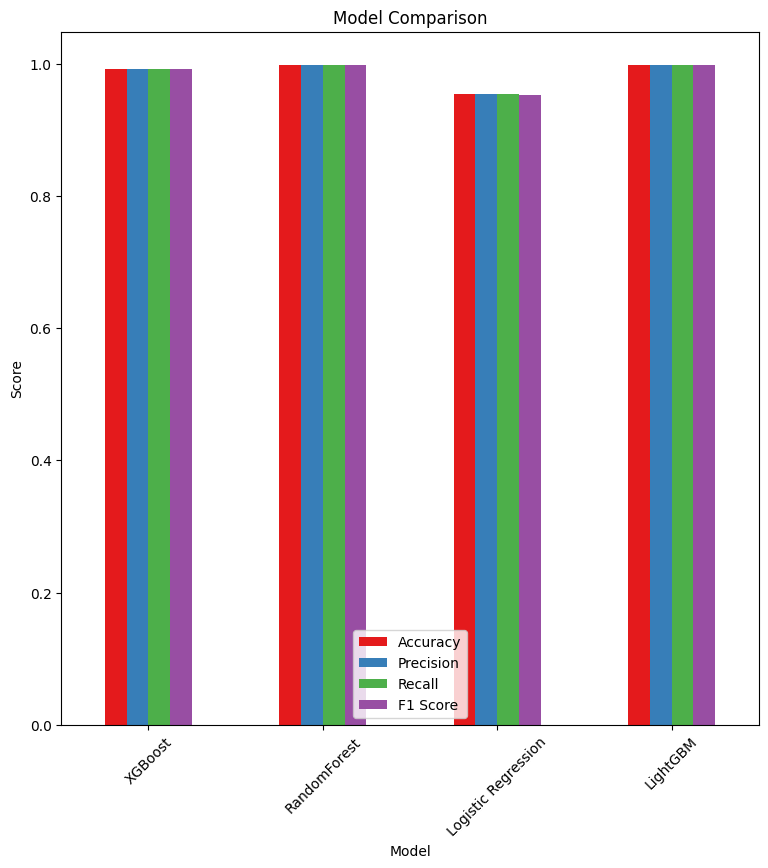

In [72]:
comparison_df.set_index('Model').plot(kind='bar', figsize=(9, 9), color=sns.color_palette("Set1"))
plt.title('Model Comparison')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.show()